In [1]:
import os
import copy
import cv2
import glob
import random
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms.functional import to_pil_image

In [2]:
EXTENSION = ".mp4"
FRAMES = 16
BATCH_SIZE = 4
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {DEVICE} device')

Using cuda:0 device


In [3]:
def get_vids(path2dataset):
    listOfCats = os.listdir(path2dataset)
    ids = []
    labels = []
    for catg in listOfCats:
        path2catg = os.path.join(path2dataset, catg)
        listOfSubCats = os.listdir(path2catg)
        path2subCats= [os.path.join(path2catg, vid) for vid in listOfSubCats]
        ids.extend(path2subCats)
        if catg == 'negative_samples':
            catg = 'No_Accident_Detected'
        else:
            catg = 'Accident_Detected'
        labels.extend([catg]*len(listOfSubCats))
    return ids, labels

In [4]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x

In [5]:
def get_frames(filename, n_frames= 1):
    v_cap = cv2.VideoCapture(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    height = v_cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    if height != 720:
        return [], v_len, False
    fps = v_cap.get(cv2.CAP_PROP_FPS)
    duration = v_len/fps
    if duration<3 or duration>16:
        return [], v_len, False
    frames = []
    frame_list= np.linspace(0, v_len-1, n_frames+1, dtype=np.int16)
    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
            frames.append(frame)
    v_cap.release()
    return frames, v_len, True

In [6]:
def transform_frames(frames, model_type="rnn"):
    if model_type == "rnn":
        h, w = 224, 224
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        h, w = 112, 112
        mean = [0.43216, 0.394666, 0.37645]
        std = [0.22803, 0.22145, 0.216989]

    test_transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)]) 

    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)    

    if model_type=="3dcnn":
        imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
    imgs_tensor = imgs_tensor.unsqueeze(0)
    return imgs_tensor

In [7]:
def store_frames(frames, path2store):
    for ii, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
        path2img = os.path.join(path2store, "frame"+str(ii)+".jpg")
        cv2.imwrite(path2img, frame)

In [8]:
path2data = "/kaggle/input/hwid12-highway-incidents-detection-dataset/Video-Accident-Dataset"
path2dataset = "/kaggle/working/Accident-Dataset-Keyframes"
path2Cats = path2data
Categories = os.listdir(path2Cats)
Categories

['other_crash',
 'rollover',
 'fire_or_explosions',
 'rear_collision',
 'drifting_or_skidding',
 'objects_falling',
 'pedestrian_hit',
 'collision_with_stationary_object',
 'negative_samples',
 'side_collision',
 'collision_with_motorcycle',
 'head_on_collision']

In [9]:
for cat in Categories:
    print("Category:", cat)
    path2acat = os.path.join(path2Cats, cat)
    listOfSubs = os.listdir(path2acat)
    print("No of Videos:", len(listOfSubs))
    print("-"*50)

Category: other_crash
No of Videos: 88
--------------------------------------------------
Category: rollover
No of Videos: 238
--------------------------------------------------
Category: fire_or_explosions
No of Videos: 28
--------------------------------------------------
Category: rear_collision
No of Videos: 153
--------------------------------------------------
Category: drifting_or_skidding
No of Videos: 312
--------------------------------------------------
Category: objects_falling
No of Videos: 39
--------------------------------------------------
Category: pedestrian_hit
No of Videos: 11
--------------------------------------------------
Category: collision_with_stationary_object
No of Videos: 271
--------------------------------------------------
Category: negative_samples
No of Videos: 1112
--------------------------------------------------
Category: side_collision
No of Videos: 210
--------------------------------------------------
Category: collision_with_motorcycle
No of

In [10]:
for root, dirs, files in os.walk(path2Cats, topdown=True):
    if len(dirs) == 0:
        cat = root.split('/')[-1]
        cnt = 0
        for name in files:
            if EXTENSION not in name:
                continue
            path2vid = os.path.join(root, name)
            frames, vlen, chk = get_frames(path2vid, n_frames= FRAMES)
            if not chk:
                continue
            cnt += 1
            path2store = path2vid.replace(path2data, path2dataset)
            path2store = path2store.replace(name, name.split("_")[-1].split(".")[0])
            #print(path2store)
            os.makedirs(path2store, exist_ok= True)
            store_frames(frames, path2store)
        print(f'Category: {cat}\nVideos converted into Frames: {cnt}')
        print("-"*50)  

Category: other_crash
Videos converted into Frames: 85
--------------------------------------------------
Category: rollover
Videos converted into Frames: 230
--------------------------------------------------
Category: fire_or_explosions
Videos converted into Frames: 28
--------------------------------------------------
Category: rear_collision
Videos converted into Frames: 149
--------------------------------------------------
Category: drifting_or_skidding
Videos converted into Frames: 306
--------------------------------------------------
Category: objects_falling
Videos converted into Frames: 38
--------------------------------------------------
Category: pedestrian_hit
Videos converted into Frames: 11
--------------------------------------------------
Category: collision_with_stationary_object
Videos converted into Frames: 247
--------------------------------------------------
Category: negative_samples
Videos converted into Frames: 809
-------------------------------------------

In [11]:
all_vids, all_labels = get_vids(path2dataset) 
len(all_vids), len(all_labels)

(2427, 2427)

In [12]:
all_vids[:5], all_labels[:5]

(['/kaggle/working/Accident-Dataset-Keyframes/head_on_collision/138',
  '/kaggle/working/Accident-Dataset-Keyframes/head_on_collision/3',
  '/kaggle/working/Accident-Dataset-Keyframes/head_on_collision/154',
  '/kaggle/working/Accident-Dataset-Keyframes/head_on_collision/112',
  '/kaggle/working/Accident-Dataset-Keyframes/head_on_collision/10'],
 ['Accident_Detected',
  'Accident_Detected',
  'Accident_Detected',
  'Accident_Detected',
  'Accident_Detected'])

In [13]:
labels_dict = {'Accident_Detected': 1, 'No_Accident_Detected': 0}
labels_dict 

{'Accident_Detected': 1, 'No_Accident_Detected': 0}

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(all_vids, all_labels, test_size=0.25, random_state=42, stratify=all_labels)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

In [15]:
np.unique(y_train, return_counts=True)

(array(['Accident_Detected', 'No_Accident_Detected'], dtype='<U20'),
 array([1031,  516]))

In [16]:
np.unique(y_val, return_counts=True)

(array(['Accident_Detected', 'No_Accident_Detected'], dtype='<U20'),
 array([182,  91]))

In [17]:
np.unique(y_test, return_counts=True)

(array(['Accident_Detected', 'No_Accident_Detected'], dtype='<U20'),
 array([405, 202]))

In [18]:
x_train[:5], y_train[:5]

(['/kaggle/working/Accident-Dataset-Keyframes/head_on_collision/55',
  '/kaggle/working/Accident-Dataset-Keyframes/head_on_collision/82',
  '/kaggle/working/Accident-Dataset-Keyframes/collision_with_stationary_object/179',
  '/kaggle/working/Accident-Dataset-Keyframes/other_crash/43',
  '/kaggle/working/Accident-Dataset-Keyframes/other_crash/54'],
 ['Accident_Detected',
  'Accident_Detected',
  'Accident_Detected',
  'Accident_Detected',
  'Accident_Detected'])

In [19]:
x_val[:5], y_val[:5]

(['/kaggle/working/Accident-Dataset-Keyframes/negative_samples/394',
  '/kaggle/working/Accident-Dataset-Keyframes/negative_samples/755',
  '/kaggle/working/Accident-Dataset-Keyframes/collision_with_stationary_object/164',
  '/kaggle/working/Accident-Dataset-Keyframes/collision_with_stationary_object/199',
  '/kaggle/working/Accident-Dataset-Keyframes/collision_with_stationary_object/29'],
 ['No_Accident_Detected',
  'No_Accident_Detected',
  'Accident_Detected',
  'Accident_Detected',
  'Accident_Detected'])

In [20]:
x_test[:5], y_test[:5]

(['/kaggle/working/Accident-Dataset-Keyframes/rollover/104',
  '/kaggle/working/Accident-Dataset-Keyframes/negative_samples/423',
  '/kaggle/working/Accident-Dataset-Keyframes/drifting_or_skidding/121',
  '/kaggle/working/Accident-Dataset-Keyframes/collision_with_stationary_object/160',
  '/kaggle/working/Accident-Dataset-Keyframes/rollover/51'],
 ['Accident_Detected',
  'No_Accident_Detected',
  'Accident_Detected',
  'Accident_Detected',
  'Accident_Detected'])

In [21]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):      
        self.transform = transform
        self.ids = ids
        self.labels = labels
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        path2imgs = glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:FRAMES]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)
        
        seed = np.random.randint(1e9)        
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [22]:
model_type = "rnn"    

if model_type == "rnn":
    h, w = 224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [23]:
trainTransform = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),  
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),    
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
])   

In [24]:
trainDs = VideoDataset(ids=x_train, labels=y_train, transform=trainTransform)
len(trainDs)

1547

In [25]:
imgs, label = trainDs[9]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 224, 224]), 1, tensor(-2.1179), tensor(2.5529))

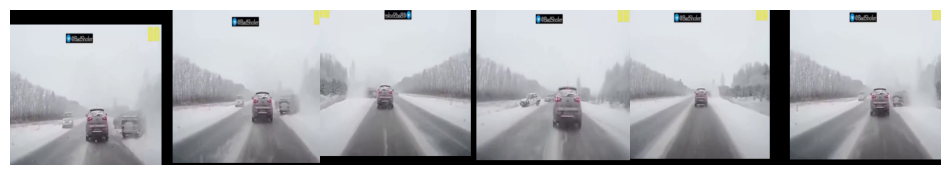

In [26]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for ii, img in enumerate(imgs[::3]):
    plt.subplot(1,10,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.axis("off")

In [27]:
testTransform = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
]) 
valDs = VideoDataset(ids=x_val, labels=y_val, transform=testTransform)
testDs = VideoDataset(ids=x_test, labels=y_test, transform=testTransform)
len(valDs), len(testDs)

(273, 607)

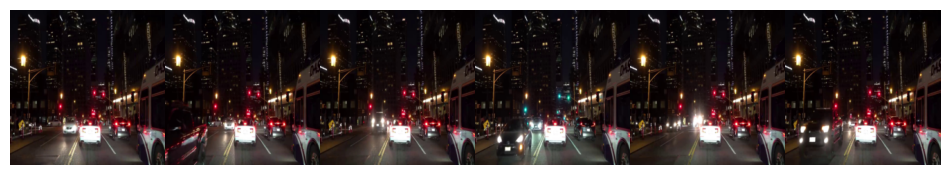

In [28]:
imgs, label = testDs[9]
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for ii, img in enumerate(imgs[::3]):
    plt.subplot(1,10,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.axis("off")

In [29]:
def collateRNN(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor, labels_tensor

In [30]:
trainDL = DataLoader(trainDs, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collateRNN)
valDL = DataLoader(valDs, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collateRNN)
testDL = DataLoader(testDs, batch_size=2*BATCH_SIZE, shuffle=False, collate_fn=collateRNN)

In [31]:
for xb, yb in trainDL:
    print(xb.shape, yb.shape)
    break
for xb, yb in valDL:
    print(xb.shape, yb.shape)
    break
for xb, yb in testDL:
    print(xb.shape, yb.shape)
    break

torch.Size([4, 16, 3, 224, 224]) torch.Size([4])
torch.Size([4, 16, 3, 224, 224]) torch.Size([4])
torch.Size([8, 16, 3, 224, 224]) torch.Size([8])


In [32]:
from torchvision.models import ResNet18_Weights
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        baseModel = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out)
        out = self.relu(out)
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x  

In [33]:
params_model={
    "num_classes": 2,
    "dr_rate": 0.1,
    "pretrained" : True,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 100,}

model = Resnt18Rnn(params_model).to(DEVICE)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Resnt18Rnn(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [34]:
with torch.no_grad():
    x = torch.zeros(1, 16, 3, h, w).to(DEVICE)
    y = model(x)
    print(y.shape)

torch.Size([1, 2])


In [35]:
path2weights = "/kaggle/working/weights.pt"
torch.save(model.state_dict(), path2weights)

In [36]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b
    
def loss_epoch(model,loss_func,dataset_dl, sanity_check=False, opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in tqdm.notebook.tqdm(dataset_dl):
        xb=xb.to(DEVICE)
        yb=yb.to(DEVICE)
        output=model(xb)
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss+=loss_b
        if metric_b is not None:
            running_metric+=metric_b
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": [],
    }
    
    metric_history={
        "train": [],
        "val": [],
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, Current Learing Rate={}'.format(epoch, num_epochs - 1, current_lr))
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        
        print("Train loss: %.6f, Validation loss: %.6f, Accuracy: %.2f" %(train_loss, val_loss, 100*val_metric))
        print("-"*50) 
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [37]:
def plot_loss(loss_hist, metric_hist):
    num_epochs= len(loss_hist["train"])
    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"], label="Train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"], label="Val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="Train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="Val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

In [38]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=0.00085)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
os.makedirs("/kaggle/working/models", exist_ok=True)

params_train={
    "num_epochs": 10,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": trainDL,
    "val_dl": valDL,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "/kaggle/working/models/weights_"+model_type+".pt",
}

model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/9, Current Learing Rate=0.00085


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Copied best model weights!
Train loss: 0.536136, Validation loss: 0.433002, Accuracy: 84.98
--------------------------------------------------
Epoch 1/9, Current Learing Rate=0.00085


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Train loss: 0.509418, Validation loss: 0.442522, Accuracy: 82.42
--------------------------------------------------
Epoch 2/9, Current Learing Rate=0.00085


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Copied best model weights!
Train loss: 0.486905, Validation loss: 0.416613, Accuracy: 87.55
--------------------------------------------------
Epoch 3/9, Current Learing Rate=0.00085


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Copied best model weights!
Train loss: 0.461751, Validation loss: 0.388162, Accuracy: 86.08
--------------------------------------------------
Epoch 4/9, Current Learing Rate=0.00085


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Train loss: 0.468861, Validation loss: 0.584381, Accuracy: 72.16
--------------------------------------------------
Epoch 5/9, Current Learing Rate=0.00085


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Train loss: 0.468705, Validation loss: 0.422093, Accuracy: 81.68
--------------------------------------------------
Epoch 6/9, Current Learing Rate=0.00085


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Copied best model weights!
Train loss: 0.449633, Validation loss: 0.369076, Accuracy: 90.11
--------------------------------------------------
Epoch 7/9, Current Learing Rate=0.00085


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Train loss: 0.488113, Validation loss: 0.506376, Accuracy: 71.79
--------------------------------------------------
Epoch 8/9, Current Learing Rate=0.00085


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Train loss: 0.448085, Validation loss: 0.369196, Accuracy: 89.38
--------------------------------------------------
Epoch 9/9, Current Learing Rate=0.00085


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Train loss: 0.448955, Validation loss: 0.396761, Accuracy: 85.71
--------------------------------------------------


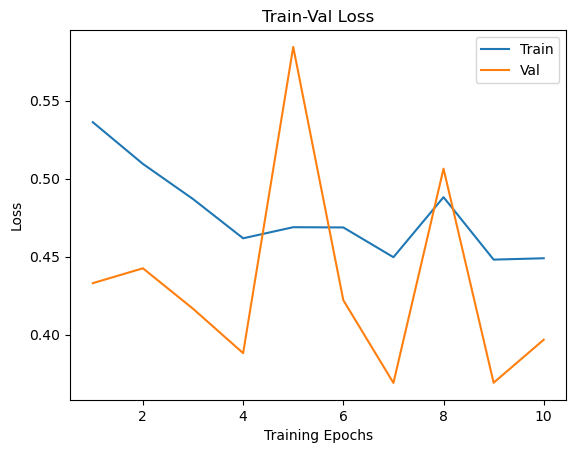

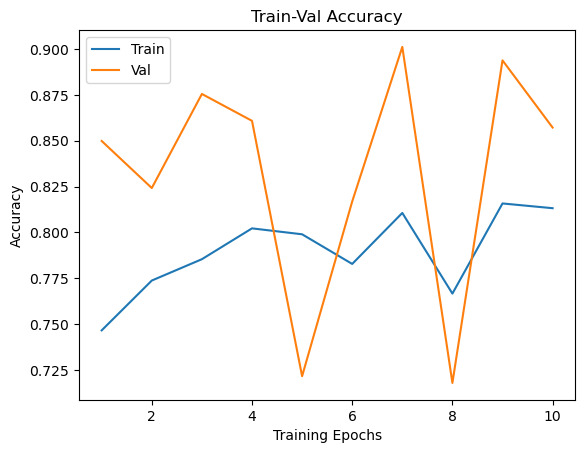

In [39]:
plot_loss(loss_hist, metric_hist)

In [40]:
with torch.no_grad():
    testLoss, testAcc = loss_epoch(model, loss_func, testDL)
    print("Test loss: %.6f, Accuracy: %.2f" %(testLoss, 100*testAcc))

  0%|          | 0/76 [00:00<?, ?it/s]

Test loss: 0.373098, Accuracy: 90.28


In [41]:
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for video_batch, labels  in tqdm.notebook.tqdm(testDL):
        video_batch, labels = video_batch.to(DEVICE), labels.to(DEVICE)
        output = model(video_batch)
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        labels = labels.cpu().numpy()
        y_pred.append(output)
        y_true.append(labels)

  0%|          | 0/76 [00:00<?, ?it/s]

In [42]:
y_true = np.hstack(y_true)
y_pred = np.hstack(y_pred)

In [43]:
df = pd.DataFrame((y_true, y_pred), index = ['Label', 'Prediction'])
df

,0,1,2,3,4,5,6,7,8,9,...,597,598,599,600,601,602,603,604,605,606
Label,1,0,1,1,1,0,0,1,0,0,...,1,1,0,1,1,0,0,1,1,1
Prediction,1,1,1,1,1,0,0,1,0,0,...,1,1,0,1,1,0,0,1,1,1


<AxesSubplot:>

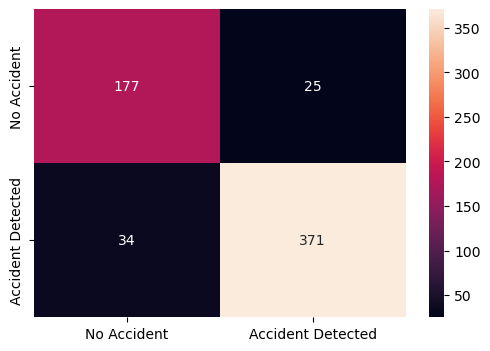

In [44]:
classes = ('No Accident', 'Accident Detected')
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (6, 4))
sns.heatmap(df_cm, annot=True, fmt="d")

In [45]:
print("Precision:\t"+str(precision_score(y_true, y_pred)))
print("Recall:\t"+str(recall_score(y_true, y_pred)))
print("F1-Score:\t"+str(f1_score(y_true, y_pred)))

Precision:	0.9368686868686869
Recall:	0.9160493827160494
F1-Score:	0.9263420724094882
